<a href="https://colab.research.google.com/github/tedteske/CRE_Monte_Carlo/blob/master/CRE_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries and class definition


In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm, skew
import statsmodels.api as sm  # for calculating elasticities

pd.options.mode.chained_assignment = None  # solve why this is necessary
# pd.set_option('max_columns', None)  # to prevent pandas truncating print(df)
pd.reset_option('max_columns')  # to reset to default setting


class apartment_complex:

    def __init__(self, project_params, common_params, description=None):

        self.description = description
        self.project_params = project_params 
        # because used in print_simulation()
        
        self.v = common_params.copy()
        self.v.update(project_params) 
        # project_params override common_params where equal
        
        for k in sorted(self.v.keys()): 
            self.v[k] = self.parse_input_params(self.v[k])
        self.v = pd.DataFrame.from_dict(self.v, orient='columns')
        # self.iter_params()
        
    def parse_input_params(self, var_params):
        '''     
        Converts model parameter item to a list of length 5 and fill blanks. 

        Parameters
        ----------
        var_params (list) : mu, sigma, lower bound, upper bound; 
            not always complete

        Returns
        -------
        var_params (list) : mu, sigma, lower bound, upper bound, 0; 
            Last list item is a placeholder for a single sample draw.
        '''

        if type(var_params) in (int, float): 
            var_params = [var_params]
        
        var_params = var_params + [0, None, None, None, None][len(var_params):] 
        var_params[2] = var_params[2] if var_params[2] is not None else -np.inf
        var_params[3] = var_params[3] if var_params[3] is not None else np.inf
        var_params[4] = var_params[4] if var_params[4] is not None else 0

        return var_params    
    
    def sample_draw(self, var_params):
        '''
        Draws normal variates subject to lower and upper bounds. [1]

        Parameters
        ----------
        var_params (list) : mu, sigma, lower bound, upper bound

        Returns
        -------
        draw (float) : random variate from normal or truncnorm distribution
        
        Notes
        -----
        [1] see for a description of the method
            http://web.ist.utl.pt/~ist11038/compute/qc/,truncG#/lecture4k.pdf
        '''
        
        mu, sigma, lower, upper = var_params[:4]
        
        if sigma in (None, 0) or np.isnan(sigma):
            draw = mu
        else:      
            if np.isinf(lower) and np.isinf(upper): 
                # If no upper or lower bounds, draw from normal distribution.  
                draw = norm.rvs(loc=mu, scale=sigma) 
            else:  
                # Else draw from truncnorm distribution.
                lower_std, upper_std = (lower-mu)/sigma, (upper-mu)/sigma
                
                lower_pdf = norm.pdf(lower_std, loc=0, scale=1)
                upper_pdf = norm.pdf(upper_std, loc=0, scale=1)
                
                lower_cdf = norm.cdf(lower_std, loc=0, scale=1)
                upper_cdf = norm.cdf(upper_std, loc=0, scale=1)

                if np.isfinite(lower) and np.isfinite(upper): 
                    # If both lower and upper finite
                    a = upper_std * upper_pdf - lower_std * lower_pdf
                    b = upper_cdf - lower_cdf
                    c = ((upper_pdf - lower_pdf) / (upper_cdf - lower_cdf))**2               
                elif np.isfinite(lower):
                    # If lower but not upper is finite
                    a = lower_std * lower_pdf
                    b = 1 - lower_cdf
                    c = (lower_pdf / (1 - lower_cdf))**2
                else:
                    # If upper but not lower is finite
                    a = upper_std * upper_pdf
                    b = upper_cdf
                    c = (upper_pdf / upper_cdf)**2
                    
                sigma2 = np.sqrt(sigma**2/(1 - a/b - c))
                
                pdf_diff = upper_pdf - lower_pdf
                cdf_diff = upper_cdf - lower_cdf
                mu2 = mu + (sigma2 * pdf_diff / cdf_diff)
                
                draw = truncnorm.rvs((lower - mu2)/sigma2,
                                     (upper - mu2)/sigma2,
                                     loc=mu2, scale=sigma2)
                
            # to give draw same number of decimal places as mu
            # draw = round(draw, len(str(mu).split('.')[1])) 

        return draw
    
    def draw_params(self, s):
        '''
        Applies sample draw to full set of variables and append draw set to 
        dataframe

        Parameters
        ----------
        s (int) : simulation index
        '''
       
        self.v.loc[s] = self.v.loc[:4].apply(self.sample_draw, 
                                             axis=0, raw=False)
                 
    def iter_params(self, n=10): 
        '''
        Runs draw_params, simulate n times, appends simulations to multiindex 
        dataframe.

        Parameters
        ----------
        s (int) : simulation index
        n (int) : number of iterations (default 10)    
        ''' 

        index = range(5, n + 5)
        columns = self.v.columns
        df = pd.DataFrame(index=index, columns=columns)
        df = df.fillna(0)  # with 0s rather than NaNs
      
        self.v = pd.concat([self.v[:5], df])
        
        func = lambda x: self.sample_draw(self.v[col])       
        for col in columns:     
            self.v[col][5:] = self.v[col][5:].apply(func)
    
        p = pd.concat([self.simulate(0)], keys=[0])
        for s in index:
            p2 = pd.concat([self.simulate(s)], keys=[s])
            p = pd.concat([p, p2])    
              
        self.p = p
     
    def simulate(self, s=0):
        '''
        Simulates rental rates, occupancy, and cash flows.

        Parameters
        ----------
        s (int) : simulation index
            None if using last param set
            0 if default params
            4 if single new draw
            >4 if draw result of n iterations

        Returns
        -------
        DataFrame
        '''
        
        if s == 4:
            self.draw_params(s)
                
        # --- setup dataframe --- #
        index = range(0, int(self.v["years"][s]) + 1)
        columns = ['OCC', 'RATE', 'PURCH_SALE', 'CAPEX_MAINT', 'CAPEX_REHAB', 
                   'LOAN', 'PMT',
                   'REV_BASE', 'REV_PREMS', 'OE', 'NOI',
                   'FCFE', 'DSCR', 'NOIM', 'COC', 'DEBT_Y', 'IRR', 'NPV']
        df = pd.DataFrame(index=index, columns=columns)
        df = df.fillna(0)  # with 0s rather than NaNs
        
        # --- fill with estimated values --- #
        g_years = df.index.to_numpy() - 1
        growth_costs_factor = (1 + self.v['growth_costs'][s])**g_years
        growth_revs_factor = (1 + self.v['growth_revs'][s])**g_years
        
        df['CAPEX_MAINT'][0] = -self.v['deferred_maint'][s]
        df['CAPEX_MAINT'][1:] = (self.v['rental_units'][s] 
                                 * -self.v['maint_reserve_per_unit'][s])
        df['CAPEX_MAINT'][1:] = (df['CAPEX_MAINT'] * growth_costs_factor)[1:] 
            
        stab_year = int(self.v['transition_years'][s] + 1)
        df['OCC'] = (self.v['occ_now'][s] 
                     + (self.v['occ_stab'][s] - self.v['occ_now'][s]) 
                     * (2 * df.index - 1)/(2 * self.v['transition_years'][s]))
        df['OCC'][0] = self.v['occ_now'][s]
        df['OCC'][stab_year:] = self.v['occ_stab'][s]
        
        df['RATE'] = ((self.v['rent_rate_stab'][s] 
                       - self.v['rent_rate_now'][s]) 
                      * (2 * df.index - 1) 
                      / (2 * self.v['transition_years'][s]) 
                      + self.v['rent_rate_now'][s])
        df['RATE'][0] = self.v['rent_rate_now'][s]
        df['RATE'][stab_year:] = self.v['rent_rate_stab'][s]
        
        df['REV_BASE'] = (df['RATE'] * 12 
                          * growth_revs_factor 
                          * (1 + self.v['other_income'][s]) 
                          * (1 - self.v['credit_loss'][s])
                          * self.v['rental_units'][s] 
                          * df['OCC'])
        
        rehab_costs, rehab_prems = self.rehab_effects(s)
        df['REV_PREMS'][1:] = rehab_prems
        df['CAPEX_REHAB'][1:] = -rehab_costs
        
        if np.isnan(self.v['oe_per_unit'][s]):
            df['OE'] = (-self.v['oe_ratio'][s] 
                        * df['REV_BASE'][1]
                        * growth_costs_factor) 
        else:    
            df['OE'] = (-self.v['oe_per_unit'][s] 
                        * self.v['rental_units'][s] 
                        * growth_costs_factor)
        
        df['OE'] = (df['OE'] 
                    + (df['REV_BASE'] + df['REV_PREMS']) 
                    * -self.v['mgmt_fee'][s])
        
        df['REV_BASE'][0], df['REV_PREMS'][0], df['OE'][0] = 0, 0, 0
        df['NOI'] = df['REV_BASE'] + df['REV_PREMS'] + df['OE']
        
        appraisal_NOI, appraisal = self.appraisal()
        if np.isnan(self.v['purch_price'][s]): 
            df['PURCH_SALE'][0] = -appraisal
        else:
            df['PURCH_SALE'][0] = -self.v['purch_price'][s]
        df['PURCH_SALE'][self.v['years'][s]] = (df['NOI'][self.v['years'][s]]
                                                / self.v['caprate_exit'][s])
        
        loan, payoff, pmt, io_pmt = self.loan(appraisal_NOI, appraisal, s)
        df['LOAN'][0] = loan
        df['PMT'][1:] = pmt
        df['PMT'][1:int(self.v['loan_IO_term'][s] + 1)] = io_pmt
        df['LOAN'][self.v['years'][s]] = payoff
        
        df['FCFE'] = (df['PURCH_SALE'] + df['CAPEX_MAINT'] + df['CAPEX_REHAB'] 
                      + df['LOAN'] + df['PMT'] + df['NOI'])
        
        # Debt Service Coverage Ratio
        df['DSCR'] = df['NOI'][1:] / -df['PMT'][1:] 
        
        # Cumulative levered IRR to end of year
        df['IRR'] = df['FCFE'].expanding().apply(np.irr, raw=False) 
        
        # Cash-on-cash return
        df['COC'] = df['FCFE'][1:] / -df['FCFE'][0]  
        
        # Net Present Value
        df['NPV'] = np.nan 
        df['NPV'][-1:] = np.npv(self.v['discount_rate'][s], df['FCFE'])
        
        # NOI margin
        df['NOIM'] = df['NOI'][1:] / (df['REV_BASE'][1:] + df['REV_PREMS'][1:])

        # Debt Yield
        df['DEBT_Y'] = df['NOI'][1:] / loan 
        
        self.simulation = df
        
        return self.simulation
    
    def IRR_attrib(self, s=0, summary=False, formatted=True):
        '''     
        Decomposes levered IRR [1] into contributions from 
            market_effects
                NOI_baseline : Year 1 NOI held constant over term
                capex_maint : deferred maintenance and maintenance-type capex
                caprate_compression : capital gains from of change in caprate 
            mgmt_effects
                NOI_improvement
                capex_rehab
                purch_sale_at_caprate_entry
            leverage

        Parameters
        ----------
        s (int) : simulation index
        summary (bool) : if True, group by market_effects, mgmt_effects, 
            and leverage
        formatted (bool or str) : 
            if True, return DataFrame.
                with money and rate columns formatted for readability
            if 'pretty', format and pretty print
            if False, return DataFrame, unformatted

        Returns
        -------
        contribs (DataFrame or string print) : levered IRR, decomposed
        
        Notes
        -----
        [1] see for a description of the method
            https://www.mckinsey.com/business-functions/
            strategy-and-corporate-finance/our-insights/
            a-better-way-to-understand-internal-rate-of-return
        '''

        df = self.p.copy()
        
        def nfv(rate, vals):
            # net future value
            count = len(vals)-2
            return np.npv(rate, vals) * (1 + rate)**count

        leverage_ = df['LOAN'].loc[s] + df['PMT'].loc[s]

        IRR_unlev = np.irr(df['FCFE'].loc[s] - leverage_)
        leverage = df['IRR'].loc[s].iloc[-1] - IRR_unlev

        NOI_baseline_ = df['NOI'].loc[s].copy()
        NOI_baseline_[1:] = NOI_baseline_[1]
        NOI_baseline = nfv(IRR_unlev, NOI_baseline_)

        capex_maint = nfv(IRR_unlev, df['CAPEX_MAINT'].loc[s])

        NOI_improvement = df['NOI'].loc[s] - NOI_baseline_
        NOI_improvement = nfv(IRR_unlev, NOI_improvement)

        capex_rehab = nfv(IRR_unlev, df['CAPEX_REHAB'].loc[s])

        purch = df['PURCH_SALE'].loc[s].iloc[0]
        sale_at_caprate_entry = (df['NOI'].loc[s].iloc[-1]
                                 / self.v['caprate_entry'].loc[s])
        purch_sale_at_caprate_entry = purch + sale_at_caprate_entry

        caprate_compression = (df['NOI'].loc[s].iloc[-1]
                               / self.v['caprate_exit'].loc[s] 
                               - sale_at_caprate_entry)

        contribs = {'NOI_baseline': NOI_baseline,
                    'capex_maint': capex_maint,
                    'caprate_compression': caprate_compression,
                    'NOI_improvement': NOI_improvement,
                    'capex_rehab': capex_rehab,
                    'purch_sale_at_caprate_entry': purch_sale_at_caprate_entry}
        contribs = pd.Series(contribs)
        contribs = contribs/sum(contribs) * IRR_unlev
        contribs = contribs.append(pd.Series({'leverage': leverage}))

        if summary:  
            contribs = {'market_effects': contribs[:3].sum(),
                        'mgmt_effects': contribs[3:6].sum(),
                        'leverage': leverage}
            contribs = pd.Series(contribs)
            
        if formatted:
                return contribs.map('{:.1%}'.format)
        else:
            return contribs
       
    def appraisal(self, s=0):
        '''
        Estimates an initial appraisal value and appraiser's assumed NOI.
        
        Parameters
        ----------
        s (int) : simulation index

        Returns
        -------
        appraisal_NOI (float)
        appraisal (float)
        ''' 

        revs_per_unit = (self.v['rent_rate_stab'][s] * 12 
                         * (1 + self.v['other_income'][s]) 
                         * (1 - self.v['credit_loss'][s])
                         * self.v['occ_stab'][s])
        if np.isnan(self.v['oe_per_unit'][s]):
            oe_per_unit = -self.v['oe_ratio'][s] * revs_per_unit
        else:
            oe_per_unit = -self.v['oe_per_unit'][s]
        oe_per_unit += -self.v['mgmt_fee'][s] * revs_per_unit
        
        appraisal_NOI = ((revs_per_unit + oe_per_unit) 
                         * self.v['rental_units'][s])
        appraisal = appraisal_NOI / self.v['caprate_entry'][s]
        
        return appraisal_NOI, appraisal 
    
    def loan(self, appraisal_NOI, appraisal, s=0):
        '''
        Calculates loan amount (PV), loan payment (PMT), payoff (FV), 
        and io_pmt; subject to LTV and DSCR constraints.
               
        Parameters
        ----------
        s (int) : simulation index

        Returns
        -------
        loan (float) : loan principle amount
        payoff (float) : loan payoff or balloon payment at end of horizon
        PMT (float) : annual loan payment
        io_pmt (float) : interest-only payment during IO term
        ''' 
               
        rate = self.v['loan_rate'][s]
        amort = self.v['loan_amort'][s]
        LTV = self.v['loan_constraint_LTV'][s]
        DSCR = self.v['loan_constraint_DSCR'][s]
        years = self.v['years'][s]
        loan_IO_term = self.v['loan_IO_term'][s]
        costs = self.v['loan_costs'][s]
        loan_amount = self.v['loan_amount'][s]

        PVAfactor = (1 - (1 + rate)**-amort) / rate
        FV_factor = (1 + rate)**(years - loan_IO_term)

        if np.isnan(loan_amount):
            PV = appraisal * LTV / (1 + costs) 
            PMT = -min(PV / PVAfactor, appraisal_NOI / DSCR)
            PV = PMT * PVAfactor  # in case PV limited by DSCR
        else:
            PV = loan_amount
            PMT = PV / PVAfactor
        
        payoff = PV * FV_factor - PMT * ((FV_factor - 1) / rate)
        loan = -PV * (1 - costs)  # so sign shows CF direction
        io_pmt = PV * rate 
        
        return loan, payoff, PMT, io_pmt 
    
    def rehab_effects(self, s=0):
        '''
        Spreads rent-enhancing rehab costs and benefits over horizon.
               
        Parameters
        ----------
        s (int) : simulation index

        Returns
        -------
        rehab_costs (array)
        rehab_prems (array)
        '''

        turnover = self.v['turnover'][s] 
        rental_units = self.v['rental_units'][s]
        years = self.v['years'][s]
        rehab_opps = np.ceil(turnover**np.arange(0, years) * rental_units)

        cost_per_rehab = self.v['rehab_cost'][s]
        growth_costs = self.v['growth_costs'][s]
        growth_costs_factors = (1 + growth_costs)**np.arange(0, years) 
        costs = growth_costs_factors * cost_per_rehab
        rehab_costs = costs * rehab_opps * turnover

        rehab_prem = self.v['rehab_prem'][s]
        growth_revs = self.v['growth_revs'][s]
        occ = self.v['occ_stab'][s] 
        growth_revs_factors = (1 + growth_revs)**np.arange(0, years)
        rehab_benefits_unit = growth_revs_factors * rehab_prem * 12 * occ
        rehab_prems = (rental_units - rehab_opps) * rehab_benefits_unit 
        
        return rehab_costs, rehab_prems
   
    def print_simulation(self, s=None, transpose=True, formatted=True):
        '''
        Pretty prints or returns DataFrame of a single simulation. 

        Parameters
        ----------
        s (int) : simulation index
                None if using last param set
                0 if default params
                4 if single new draw
                >4 if draw result of n iterations
        transpose (bool) : if True, move columns to rows
        formatted (bool or str) : 
            if True, return DataFrame.
                with money and rate columns formatted for readability
            if 'pretty', format and pretty print
            if False, return DataFrame, unformatted

        Returns
        -------
        DataFrame if formatted=='pretty'
        '''
        
        if s is None:
            try:
                df = self.simulation.copy()
            except:
                df = self.simulate(0).copy()
        else: 
            df = self.simulate(s).copy()
        
        if formatted is not False:
            df = self.format_columns(df)

        if formatted == 'pretty':
            df[' '] = " "   # used as a spacer
            df = df[['OCC', 'RATE', 
                     ' ', 'REV_BASE', 'REV_PREMS', 'OE', 'NOI', 
                     ' ', 'PURCH_SALE', 'CAPEX_MAINT', 'CAPEX_REHAB', 
                     ' ', 'LOAN', 'PMT',
                     ' ', 'FCFE', 'DSCR', 'NOIM', 'COC', 'DEBT_Y', 
                     'IRR', 'NPV']]
            
            df = df.T  # ignoring transpose flag, transpose if pretty print
            if self.description is None:
                title = "SIMULATION " + str(s)
            else:    
                title = str(self.description).upper() + " SIMULATION " + str(s)
            print(title)
            print("=" * len(title))
            print(df)
        
        else: 
            if transpose:
                df = df.T
            return df

    def top(self, col, n=3, year=None, bottom=False, formatted=True):
        '''     
        Pretty prints or returns DataFrame of top (or bottom) n simulations 
        sorted by column col.

        Parameters
        ----------
        col (str or list of str) : param or simulation column
        n (int) : number of simulations printed (default 3)
        year (int) : year in horizon over which to calculate summary stats 
            of a simulation result. Ignored if summarizing a param.
        bottom (bool) : if True, take bottom, rather than top, n simulations
        formatted (bool or str) : 
            if True, return DataFrame.
                with money and rate columns formatted for readability
            if 'pretty', format and pretty print
            if False, return DataFrame, unformatted

        Returns
        -------
        DataFrame if formatted=='pretty'
        '''
    
        df = self.p.copy()
        
        try:
            var = self.v[col][5:]
        except:
            if year is None: 
                year = self.v['years'][0]
            var = df.xs(year, level=1).iloc[5:][col]  
        
        if bottom: 
            title = "BOTTOM "
            sims = var.nsmallest(n).index
        else: 
            title = "TOP "
            sims = var.nlargest(n).index
        
        if formatted is not False:
            df = self.format_columns(df)
        
        if formatted == 'pretty':
            print(title + str(n) + " " + col + " SCENARIOS")
            for i in sims:
                print("\n")
                self.print_simulation(i, True, 'pretty')
        else:
            return df.loc[sims].stack().unstack(level=1)
    
    def format_columns(self, df):
        '''
        Styles money and rate columns for readability and removes NaNs.
        '''

        # format money columns
        for column in ['PURCH_SALE', 'CAPEX_MAINT', 'CAPEX_REHAB', 
                       'LOAN', 'PMT', 
                       'REV_BASE', 'REV_PREMS', 'OE', 'NOI', 
                       'FCFE', 'NPV']:
            df[column] = df[column].map('{:,.0f}'.format)
        df['RATE'] = df['RATE'].map('{:,.2f}'.format)

        # format rate columns
        for column in ['OCC', 'IRR', 'COC', 'NOIM', 'DEBT_Y']:
            df[column] = df[column].map('{:,.1%}'.format)
        df["DSCR"] = df['DSCR'].map('{:,.2f}'.format) 

        for column in ['DSCR', 'IRR', 'COC', 'NPV', 'NOIM', 'DEBT_Y']:
            df[column].replace(['None', 'NaN', np.nan, 'nan', 'nan%'], "", 
                               inplace=True)
        
        return df
    
    def print_params(self, s=0, print_common_params=False):   
        '''
        Pretty prints set of input params and values.  

        Parameters
        ----------
        s (int) : simulation index
                None if using last param set
                0 if default params
                4 if single new draw
                >4 if draw result of n iterations
        print_common_params (bool) : if True, include common params.
        '''
        
        df = self.v[:5]
        
        if s == 4: 
            self.draw_params(s)
        elif s > 4:
            df = pd.concat([df, self.v[s:s + 1]])
        
        assumption_set = "(estimate, stdev, min, max, draw)"
        if print_common_params:
            keys = sorted(self.v.keys())
            title = "ALL MODEL ASSUMPTIONS " + assumption_set
        else:    
            keys = sorted(self.project_params.keys())
            title = "PROJECT-SPECIFIC MODEL ASSUMPTIONS " + assumption_set
            
        print(title)
        print("=" * len(title)) 
        for k in keys: 
            print(k, ":", df[k].tolist())
    
    def describe(self, col, year=None, scale=1):
        '''
        Prints a table of summary statistics on column(s) col.

        Parameters
        ----------
        col (str or list of str) : param or simulation column
        year (int) :  year in horizon over which to calculate summary stats 
            of a simulation result; ignored if summarizing a param
        scale (float) : scales the summary statistics
        '''

        if type(col) == str:
            col = [col]
        if not hasattr(scale, '__iter__'): 
            scale = [scale] * len(col)  # if scale not an iterable
        df = pd.DataFrame()
        
        for i, c in enumerate(col):
            try:
                df = df.append(self.v[c][5:] * scale[i]) 
            except:
                if year is None:
                    year = self.v['years'][0]
                df = df.append(self.p.xs(year, level=1).iloc[5:][c] * scale[i]) 
              
        described = df.T.describe([0.05, 0.25, 0.5, 0.75, 0.95])
        print(described.applymap('{0:,.2f}'.format))
             
    def elasticities(self, col="NPV"):
        '''
        Print estimated param elasticities of col (e.g. occ_stab elasticity 
        of NPV) and associated p-values. Elasticities are estimated only for
        stochastic params.
        
        Parameters
        ----------
        col (str) : simulation column
        '''  

        year = self.v['years'][0]

        df1 = pd.DataFrame(self.p.xs(year, level=1).iloc[5:][col])
        
        s = ~np.isnan(self.v[1:2]).T[1]
        df2 = self.v[5:][[column for column in s[s==True].index]]
        df3 = df1.join(df2)
        
        df3 = df3[(df3 > 0).all(1)] 
        # removes any row with a negative number in any column
        
        OLS_dep_var = np.log(df3[col])   # response
        OLS_ind_var = np.log(df3.drop([col], axis=1))  # predictor

        elasticity_estimate = sm.OLS(OLS_dep_var, 
                                     OLS_ind_var, missing='drop').fit()

        title = "SENSITIVITY ANALYSIS: ELASTICITY OF " 
        title += str(col) + " WITH RESPECT TO UNCERTAIN ASSUMPTIONS"
        print(title)
        print("=" * len(title))
        print (pd.DataFrame({'elasticity': elasticity_estimate.params.round(2),
                             'p-value': elasticity_estimate.pvalues.round(2)}))
    
    def plot_col(self, col, year=None, xlabel=None, 
                 scale=1, bw=0.05, kde=True):
        '''
        Plots a distribution of columns col as a histogram or kernel density 
        estimate.

        Parameters
        ----------
        col (str) : simulation column
        year (int) :  year in horizon over which to plot simulation results; 
            ignored if summarizing a param
        scale (float) : scales the variable
        xlabel (str) : label for the x-axis
        bw (float) : bandwidth
        kde (bool) : If True, display as kernel denisity estimate.
            If False, display as histogram.
                
        Example Usage
        ------------- 
        plot_col("NPV",scale=1/1e6, xlabel="NPV ($M)")
        plot_col("IRR",scale=100, xlabel="IRR (%)")
        plot_col("occ_stab",scale=100, xlabel="occ_stab (%)")
        '''
      
        try:
            var = self.v[col][5:]
        except:
            if year is None:
                year = self.v['years'][0]
            var = self.p.xs(year, level=1).iloc[5:][col]

        var = var.dropna()
        var = var * scale

        avg, stdev = np.mean(var), np.std(var)
        min_, max_ = np.min(var), np.max(var)
        conf_int_low = max(min_, avg - stdev * 1.96)
        conf_int_high = min(max_, avg + stdev * 1.96)       
        
        plt.figure(figsize=(10, 10/1.6)) 
        ax = sns.distplot(var, kde=kde, hist=not kde, label=col,
                          norm_hist=True, kde_kws={'bw': bw, 'shade': True})
        ax.set(xlabel=xlabel, 
               ylabel="relative frequency")

        if kde:
            c = ax.get_lines()[-1].get_c()    
            plt.axvline(avg, color=c, linestyle='dashed', label=r'$\bar{x}$')
            plt.axvline(conf_int_low, color=c, linestyle='dotted', 
                        label=r'$\bar{x} \pm 2s$')
            plt.axvline(conf_int_high, color=c, linestyle='dotted')      

        leg = plt.legend(fontsize='large')
        plt.show()

### Example usage, Quail Apartments

Initialize Quail Apartments with underwriting assumptions and simulate 100 times.

In [0]:
# --- parameters (estimate, stdev, lower bound, upper bound;--- #
# --- "None" for no stdev, lower or upper)--- #

# --- project-specific params 
# --- Note these take precedence over common params where keys equal. ---#
quail_params = {  'rental_units': 50, 
                  'unit_area': 750, 
                  
                  # operations
                  'transition_years': 0,
                  'occ_now': 0.9,
                  'occ_stab': [0.90, 0.1, 0, 0.98], 
                  'rent_rate_now': 1000,  # current rates              
                  'rent_rate_stab': [1000, 50], 
                  'other_income': 0, 
                  "credit_loss": 0,
                  'oe_per_unit': [None],  # [None] if use oe_ration instead
                  'oe_ratio': [0.5, 0.05],
                  'mgmt_fee': 0.00,             
                  
                  # capex
                  'turnover': 0.5,
                  'rehab_prem': [150, 50],
                  'rehab_cost': [15000, 75],
                  'maint_reserve_per_unit': 300,
                  'deferred_maint': 200000,
                  
                  # leverage
                  'loan_rate': 0.0350,
                  'loan_constraint_LTV': 0.75,
                  'loan_constraint_DSCR': 1.25,
                  'loan_amort': 30,
                  'loan_amount': [None],  # [None] if no loan commitment
                  'loan_IO_term': 0, 
                  'loan_costs': 0,  # as a fraction of loan amount
                  
                  # growth, caprates, purchase
                  'growth_revs': [0.030, 0.015],  
                  'growth_costs': [0.025, 0.015], 
                  'caprate_entry': 0.055, 
                  'caprate_exit': [0.060, 0.01, 0.055],
                  'purch_price': [None]  # [None] if purch_price == appraisal
                  }

# --- common params --- #
common_params =  {"discount_rate": 0.10, #caprate + average growth in NOI
                  "years": 5} 
                  
# Initialize quail, an apartment complex of class apartment, 
# and run 100 simulations
quail = apartment_complex(quail_params, common_params, 
                          description = "Quail Apartments")
quail.iter_params(100)

Print proforma.

In [38]:
quail.print_simulation(0, transpose=False, formatted='pretty')

QUAIL APARTMENTS SIMULATION 0
                      0         1         2         3         4           5
OCC               90.0%     90.0%     90.0%     90.0%     90.0%       90.0%
RATE           1,000.00  1,000.00  1,000.00  1,000.00  1,000.00    1,000.00
                                                                           
REV_BASE              0   540,000   556,200   572,886   590,073     607,775
REV_PREMS             0         0    41,715    63,590    76,119      83,873
OE                    0  -270,000  -276,750  -283,669  -290,760    -298,029
NOI                   0   270,000   321,165   352,808   375,431     393,618
                                                                           
PURCH_SALE   -4,909,090         0         0         0         0   6,560,303
CAPEX_MAINT    -200,000   -15,000   -15,375   -15,759   -16,153     -16,557
CAPEX_REHAB           0  -375,000  -192,187  -102,436   -56,537     -33,114
                                                          

Break down the components of levered IRR. See for background: https://www.mckinsey.com/business-functions/strategy-and-corporate-finance/our-insights/a-better-way-to-understand-internal-rate-of-return 

In [39]:
quail.IRR_attrib(summary=False, formatted=True)

NOI_baseline                    5.2%
capex_maint                    -1.3%
caprate_compression            -2.1%
NOI_improvement                 1.3%
capex_rehab                    -3.2%
purch_sale_at_caprate_entry     8.0%
leverage                        7.1%
dtype: object

Group by the effects of the market, management, and leverage. 

In [40]:
quail.IRR_attrib(summary=True, formatted=True)

market_effects    1.8%
mgmt_effects      6.1%
leverage          7.1%
dtype: object

What are the top 3 IRR scenarios?

In [41]:
quail.top("IRR", formatted='pretty')

TOP 3 IRR SCENARIOS


QUAIL APARTMENTS SIMULATION 27
                      0         1         2         3         4           5
OCC               90.0%     95.7%     95.7%     95.7%     95.7%       95.7%
RATE           1,000.00  1,088.78  1,088.78  1,088.78  1,088.78    1,088.78
                                                                           
REV_BASE              0   624,957   644,019   663,661   683,903     704,762
REV_PREMS             0         0    49,589    75,630    90,575      99,850
OE                    0  -275,968  -276,310  -276,652  -276,995    -277,339
NOI                   0   348,989   417,297   462,639   497,483     527,273
                                                                           
PURCH_SALE   -4,909,090         0         0         0         0   8,986,441
CAPEX_MAINT    -200,000   -15,000   -15,019   -15,037   -15,056     -15,074
CAPEX_REHAB           0  -376,419  -188,443   -98,112   -52,895     -30,263
                                   

and the worst 3?

In [42]:
quail.top("IRR", bottom=True, formatted='pretty')

BOTTOM 3 IRR SCENARIOS


QUAIL APARTMENTS SIMULATION 65
                      0         1         2         3         4           5
OCC               90.0%     79.2%     79.2%     79.2%     79.2%       79.2%
RATE           1,000.00    928.70    928.70    928.70    928.70      928.70
                                                                           
REV_BASE              0   441,515   443,348   445,189   447,037     448,893
REV_PREMS             0         0    16,130    23,972    27,974      30,050
OE                    0  -217,376  -229,097  -241,451  -254,471    -268,192
NOI                   0   224,139   230,381   227,709   220,541     210,751
                                                                           
PURCH_SALE   -4,909,090         0         0         0         0   3,542,824
CAPEX_MAINT    -200,000   -15,000   -15,809   -16,661   -17,560     -18,507
CAPEX_REHAB           0  -373,712  -196,932  -107,926   -61,248     -36,886
                                

Wow, scenario 20 looks pretty bad. Review the variables used to calculate this scenario.

In [51]:
quail.print_params(65)

PROJECT-SPECIFIC MODEL ASSUMPTIONS (estimate, stdev, min, max, draw)
caprate_entry : [0.055, nan, -inf, inf, 0.0, 0.055]
caprate_exit : [0.06, 0.01, 0.055, inf, 0.0, 0.05948667952115818]
credit_loss : [0.0, nan, -inf, inf, 0.0, 0.0]
deferred_maint : [200000.0, nan, -inf, inf, 0.0, 200000.0]
growth_costs : [0.025, 0.015, -inf, inf, 0.0, 0.053922655545817835]
growth_revs : [0.03, 0.015, -inf, inf, 0.0, 0.004151633671309694]
loan_IO_term : [0.0, nan, -inf, inf, 0.0, 0.0]
loan_amort : [30.0, nan, -inf, inf, 0.0, 30.0]
loan_amount : [nan, nan, -inf, inf, 0.0, nan]
loan_constraint_DSCR : [1.25, nan, -inf, inf, 0.0, 1.25]
loan_constraint_LTV : [0.75, nan, -inf, inf, 0.0, 0.75]
loan_costs : [0.0, nan, -inf, inf, 0.0, 0.0]
loan_rate : [0.035, nan, -inf, inf, 0.0, 0.035]
maint_reserve_per_unit : [300.0, nan, -inf, inf, 0.0, 300.0]
mgmt_fee : [0.0, nan, -inf, inf, 0.0, 0.0]
occ_now : [0.9, nan, -inf, inf, 0.0, 0.9]
occ_stab : [0.9, 0.1, 0.0, 0.98, 0.0, 0.7923526506412906]
oe_per_unit : [nan, nan,

Plot the distribution of stabilized occupancy draws.

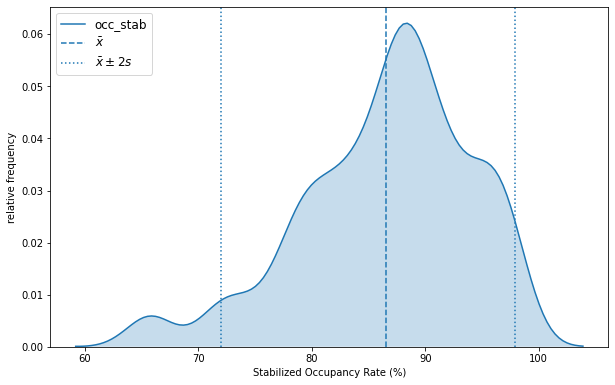

In [44]:
quail.plot_col("occ_stab", scale=100, bw=0.02*100, kde=True,
                xlabel="Stabilized Occupancy Rate (%)")

Plot the distributions of IRR and NVP to get sense of the risk in this investment.

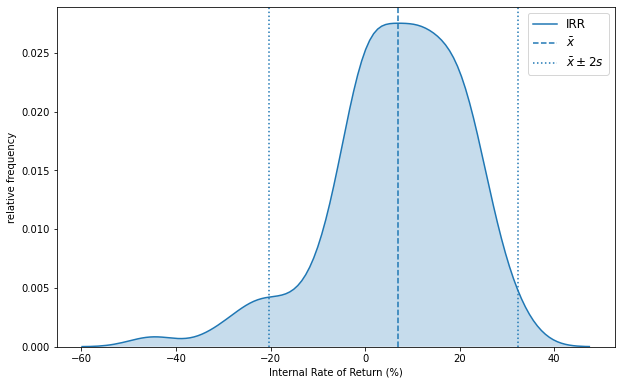

In [45]:
quail.plot_col("IRR", scale=100, bw=0.05*100, 
                xlabel="Internal Rate of Return (%)")

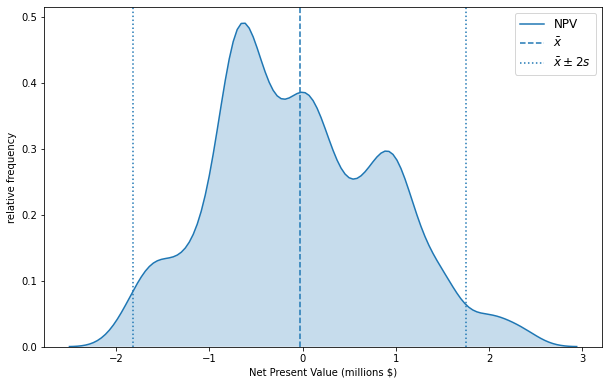

In [46]:
scale = 1/1000000
quail.plot_col("NPV", scale=scale, bw=0.2, kde=True,
                xlabel="Net Present Value (millions $)")

Is NPV symmetical about the average? Check for skew.

In [47]:
year = 5
col = "NPV"
round(skew(quail.p.xs(year, level=1).loc[5:][col]),2) 

0.48

How sensitive is NPV to the stochastic variables? Estimate elasticities.

In [48]:
quail.elasticities("NPV")

SENSITIVITY ANALYSIS: ELASTICITY OF NPV WITH RESPECT TO UNCERTAIN ASSUMPTIONS
                elasticity  p-value
occ_stab             10.03     0.00
rent_rate_stab        5.45     0.02
oe_ratio             -5.83     0.00
rehab_prem            1.20     0.00
rehab_cost           -4.90     0.01
growth_revs           2.39     0.00
growth_costs         -0.12     0.29
caprate_exit         -7.49     0.00


List some descriptive statistics for IRR, stabilized rent rate, and occupancy.

In [49]:
quail.describe(["IRR","rent_rate_stab", "occ_stab"], scale=(100, 1, 100))

          IRR rent_rate_stab occ_stab
count   96.00         100.00   100.00
mean     7.02         993.86    86.55
std     13.98          50.81     7.46
min    -44.87         858.06    65.18
5%     -20.06         919.11    72.50
25%     -0.62         962.96    82.16
50%      8.76         991.10    87.61
75%     17.40       1,022.61    91.77
95%     25.46       1,085.57    97.10
max     32.46       1,120.59    97.90


## Issues

Program should be able to match precision with user-defined mu for each variable. It works except when mu includes trailng zeroes.

In [50]:
mu = 0.90
draw = 0.98
round(draw, len(str(mu).split('.')[1]))

1.0